In [ ]:
import gc
import numpy as np
from numpy.fft import *
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from  datetime import datetime, timedelta, date

from torchvision import datasets, models, transforms



from sklearn import preprocessing, metrics
from sklearn.preprocessing import LabelEncoder



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
ColDTypes = {
          'id':'category',
          
          "item_id":"int16",  
          "dept_id":"int8",
          "store_id":"int8",
          "cat_id":"int8", 
          "state_id":"int8",


          "sales":"float32",


          "wm_yr_wk":"int16",
          "weekday":"int8",  
          "wday":"int8", 
          "month":"int8",  
          "year":"int16",
          "quarter":"int8", 


          "event_name_1":"int16",  
          "event_type_1":"int16",  
          "event_name_2":"int16",  
          "event_type_2":"int16", 

          "snap_CA":"float16",
          "snap_TX":"float16",
          "snap_WI":"float16",

          "sell_price":"float16",
          "price_momentum":"float16",
          "price_momentum_m":"float16",



          "lag_7":"float16",
          "lag_28":"float16",
          "rmean_7_7":"float16",
          "rmean_28_7":"float16",
          "rmean_7_28":"float16",
          "rmean_28_28":"float16",
}


In [ ]:
master= pd.read_csv('/content/drive/My Drive/Colab Notebooks/Content/DSF-Final.csv',dtype = ColDTypes)


FileNotFoundError: ignored

In [ ]:
master = master.loc[(master.store_id == 1) ]
gc.collect()

47

In [ ]:
master.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3042071 entries, 14238 to 32327331
Data columns (total 34 columns):
 #   Column            Dtype   
---  ------            -----   
 0   Unnamed: 0        int64   
 1   id                category
 2   item_id           int16   
 3   dept_id           int8    
 4   store_id          int8    
 5   cat_id            int8    
 6   state_id          int8    
 7   d                 object  
 8   sales             float32 
 9   date              object  
 10  wm_yr_wk          int16   
 11  weekday           int8    
 12  wday              int8    
 13  month             int8    
 14  year              int16   
 15  event_name_1      int16   
 16  event_type_1      int16   
 17  event_name_2      int16   
 18  event_type_2      int16   
 19  snap_CA           float16 
 20  snap_TX           float16 
 21  snap_WI           float16 
 22  sell_price        float16 
 23  price_mean        float64 
 24  price_momentum    float16 
 25  price_momentu

In [ ]:
unusedCols = ["Unnamed: 0",
              "wm_yr_wk",
              "quarter",
              "event_type_2",
              "event_type_1",
              "state_id",
              "store_id",
              'd'
              ]

master = master.drop(unusedCols, axis=1)

In [ ]:
submission = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Content/sample_submission.csv')

In [ ]:
def train_test_split(data):
     
    # going to evaluate with the last 28 days
    x_train = data[data['date'] <= '2016-03-27']
    y_train = x_train['sales']
    x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
    y_val = x_val['sales']
    test = data[(data['date'] > '2016-04-24')]
    del data
    gc.collect()
    return x_train, y_train, x_val, y_val, test
x_train, y_train, x_val, y_val, test= train_test_split(master)

In [ ]:
def run_lgb(x_train, y_train, x_val, y_val, test):
    

    params = {
        "objective" : "poisson",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
#         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
#         "nthread" : 4
        "metric": ["rmse"],
         'verbosity': 1,
    'num_iterations' : 1000,
    'num_leaves': 128,
    "min_data_in_leaf": 100,
    
}

    evals_result = {}

    train_set = lgb.Dataset(x_train[features], y_train)
    val_set = lgb.Dataset(x_val[features], y_val)
    
    del x_train, y_train
    catFeats = [
                'item_id',
                'dept_id',
                #'store_id',
                'cat_id',
                #'state_id'
                ] + \
              ["event_name_1",
               "event_name_2",
               "event_type_1",
              "event_type_2"
               ]  
    
    
    model = lgb.train(params, train_set, categorical_feature = catFeats,early_stopping_rounds = 200, valid_sets = [train_set, val_set], verbose_eval = 10,\
                       evals_result=evals_result)
    
    ax = lgb.plot_metric(evals_result)
    plt.show()

    lgb.plot_importance(model, importance_type="gain", precision=0, figsize=(6, 13));
    lgb.plot_importance(model, importance_type="split", precision=0, figsize=(6, 13));

    val_pred = model.predict(x_val[features], num_iteration=model.best_iteration)
    val_score = np.sqrt(metrics.mean_squared_error(val_pred, y_val))
    print(f'Our val rmse score is {val_score}')

    #y_pred = model.predict(test[features], num_iteration=model.best_iteration)
    #test['value'] = y_pred
    #del y_pred 
    #gc.collect()
    return test, model

Gain is the improvement in accuracy brought by a feature to the branches it is on.It implies the relative contribution of the corresponding feature to the model calculated by taking each feature’s contribution for each tree in the model.

Split the number of times a feature is used to split the data across all trees

In [ ]:
features = [
            
      
    "item_id",
    "dept_id",
    "cat_id",
    #"store_id",
    #"state_id",

    #event
    "event_name_1",
    "event_name_2",
    #"event_type_1",
    #"event_type_2",
                  
    "weekday",                   
    "wday",                     
    "month",                        
    "year",
    #"mday",
    #"week",

    "snap_CA",                  
    "snap_TX",                    
    "snap_WI",                   


    "sell_price",                 
                
    "price_mean",                 
    #"price_momentum",             
    "price_momentum_m",           
        
    "lag_7",                      
    "lag_28",                     
    "rmean_7_7",                  
    "rmean_28_7",                 
    "rmean_7_28",                 
    "rmean_28_28",                
                             
]






In [ ]:
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29107374 entries, 14238 to 32376115
Data columns (total 27 columns):
 #   Column            Dtype   
---  ------            -----   
 0   id                category
 1   item_id           int16   
 2   dept_id           int8    
 3   cat_id            int8    
 4   d                 object  
 5   sales             float32 
 6   date              object  
 7   weekday           int8    
 8   wday              int8    
 9   month             int8    
 10  year              int16   
 11  event_name_1      int16   
 12  event_name_2      int16   
 13  snap_CA           float16 
 14  snap_TX           float16 
 15  snap_WI           float16 
 16  sell_price        float16 
 17  price_mean        float64 
 18  price_momentum    float16 
 19  price_momentum_m  float16 
 20  price_momentum_y  float64 
 21  lag_7             float16 
 22  lag_28            float16 
 23  rmean_7_7         float16 
 24  rmean_28_7        float16 
 25  rmean_7_28  

In [ ]:
gc.collect()

112

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['cat_id', 'dept_id', 'event_name_1', 'event_name_2', 'item_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[1]	training's rmse: 2.82229	valid_1's rmse: 3.00223


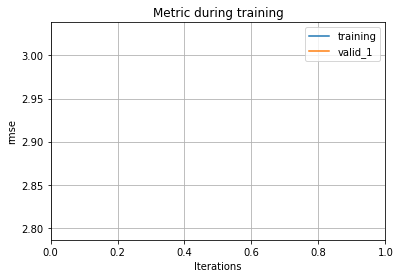

Our val rmse score is 3.002225242024343
CPU times: user 6.26 s, sys: 67.4 ms, total: 6.33 s
Wall time: 3.69 s


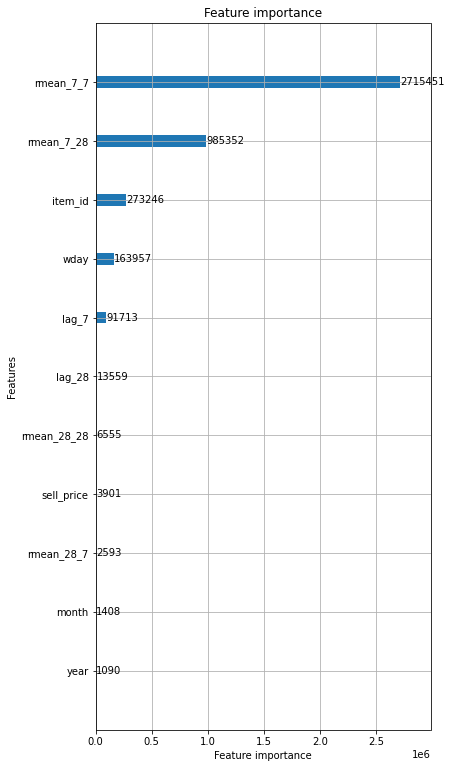

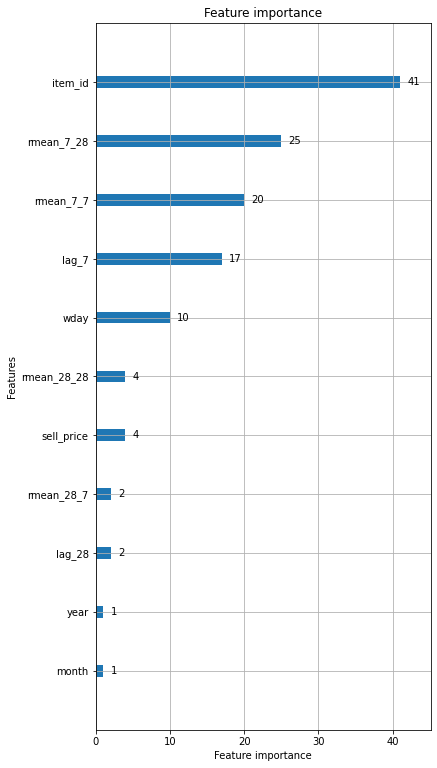

In [ ]:
 %%time
 test, model= run_lgb(x_train, y_train, x_val, y_val, test)

In [ ]:
master["date"] = pd.to_datetime(master["date"])

In [ ]:
# Last day used for training
trLast = 1941
# Maximum lag day
maxLags = 57

fday = datetime(2016,4, 25) 
alphas = [1.028, 1.023, 1.018]
weights = [1/len(alphas)] * len(alphas)
sub = 0.

for icount, (alpha, weight) in enumerate(zip(alphas, weights)):

    #te = create_ds() ca c'est mon master
    cols = [f"F{i}" for i in range(1,29)]

    for tdelta in range(0, 28):
        day = fday + timedelta(days=tdelta)
        print(tdelta, day)
        tst = master[(master['date'] >= day - timedelta(days=maxLags)) & (master['date'] <= day)].copy()
        #create_features(tst)
        tst = tst.loc[tst['date'] == day , features]
        master.loc[master['date'] == day, "sales"] = alpha * model.predict(tst) # magic multiplier by kyakovlev

    te_sub = master.loc[master['date'] >= fday, ["id", "sales"]].copy()
    te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")["id"].cumcount()+1]
    te_sub = te_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
    #te_sub.fillna(0., inplace = True)
    te_sub.sort_values("id", inplace = True)
    te_sub.reset_index(drop=True, inplace = True)
    te_sub.to_csv(f"submission_{icount}.csv",index=False)
    if icount == 0 :
        sub = te_sub
        sub[cols] *= weight
    else:
        sub[cols] += te_sub[cols]*weight
    print(icount, alpha, weight)


sub2 = sub.copy()
sub["id"] = sub["id"].str.replace("evaluation", "validation")
sub = pd.concat([sub, sub2], axis=0, sort=False)
sub
sub.to_csv("/content/drive/My Drive/Colab Notebooks/Output/Final-LGBM-Store1.csv",index=False)

0 2016-04-25 00:00:00
1 2016-04-26 00:00:00
2 2016-04-27 00:00:00
3 2016-04-28 00:00:00
4 2016-04-29 00:00:00
5 2016-04-30 00:00:00
6 2016-05-01 00:00:00
7 2016-05-02 00:00:00
8 2016-05-03 00:00:00
9 2016-05-04 00:00:00
10 2016-05-05 00:00:00
11 2016-05-06 00:00:00
12 2016-05-07 00:00:00
13 2016-05-08 00:00:00
14 2016-05-09 00:00:00
15 2016-05-10 00:00:00
16 2016-05-11 00:00:00
17 2016-05-12 00:00:00
18 2016-05-13 00:00:00
19 2016-05-14 00:00:00
20 2016-05-15 00:00:00
21 2016-05-16 00:00:00
22 2016-05-17 00:00:00
23 2016-05-18 00:00:00
24 2016-05-19 00:00:00
25 2016-05-20 00:00:00
26 2016-05-21 00:00:00
27 2016-05-22 00:00:00
0 1.028 0.3333333333333333
0 2016-04-25 00:00:00
1 2016-04-26 00:00:00
2 2016-04-27 00:00:00
3 2016-04-28 00:00:00
4 2016-04-29 00:00:00
5 2016-04-30 00:00:00
6 2016-05-01 00:00:00
7 2016-05-02 00:00:00
8 2016-05-03 00:00:00
9 2016-05-04 00:00:00
10 2016-05-05 00:00:00
11 2016-05-06 00:00:00
12 2016-05-07 00:00:00
13 2016-05-08 00:00:00
14 2016-05-09 00:00:00
15 2